## Introduction

The goals of this notebook:
* Train a unconstrained neural network model to classify kidney Cancer using Deep Learning (Tensorflow and Keras) and the UCI Chronic Kidney Disease dataset.
* Evaluate model performance specifically, Recall, overall as well across age groups. This will demonstrate that a good model overall can suffer significantly when looked at from the lens of age. This can lead to loss-of-life when applied to an age group for which the model perfoms poorly.
* Set up a constrained optimization problem to achieve consistent Recall across age groups using the Lagrangian Optimizer and Tensorflow Constrained Optimization.
* Retrain the now constrained model and evaluate performance again, ensuring that our fairness metric (Recall) has been improved across age groups. At the very least, limitations of the model across age groups is highlighted and directly optimized for during model training.

Dataset: https://archive.ics.uci.edu/ml/datasets/chronic_kidney_disease

Some tutorial articles using this dataset:

* https://mclguide.readthedocs.io/en/latest/sklearn/preprocessing.html#chronic-kidney-disease
* https://randerson112358.medium.com/chronic-kidney-disease-prediction-detection-using-machine-learning-29cc7e3eba96

In [1]:
%load_ext nb_black

<IPython.core.display.Javascript object>

In [2]:
import glob
from keras.models import Sequential, load_model
import numpy as np
import pandas as pd
import keras as k
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import tensorflow as tf

In /Users/badri/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/badri/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/badri/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /Users/badri/opt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /Users/badri/opt/anaconda3/lib/python3.7/

<IPython.core.display.Javascript object>

In [3]:
# Reproducibility
def set_seeds():
    np.random.seed(121212)
    tf.compat.v1.set_random_seed(212121)


set_seeds()

<IPython.core.display.Javascript object>

## Data review

In [4]:
# create header for dataset
header = [
    "age",
    "bp",
    "sg",
    "al",
    "su",
    "rbc",
    "pc",
    "pcc",
    "ba",
    "bgr",
    "bu",
    "sc",
    "sod",
    "pot",
    "hemo",
    "pcv",
    "wbcc",
    "rbcc",
    "htn",
    "dm",
    "cad",
    "appet",
    "pe",
    "ane",
    "classification",
]
# read the dataset
df = pd.read_csv("chronic_kidney_disease.csv", header=None, names=header)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,classification
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


<IPython.core.display.Javascript object>

## Data cleansing and pre-processing

In [5]:
# Some preprocessing to remove '?', replace TABS, NaNs etc.,
# df.replace("Nan", np.nan, inplace=True)
# df.replace("\t?", np.nan, inplace=True)
df.replace("?", np.nan, inplace=True)
df.classification.replace("ckd\t", "ckd", inplace=True)
df.head()

,age,bp,sg,al,su,rbc,pc,pcc,ba,bgr,...,pcv,wbcc,rbcc,htn,dm,cad,appet,pe,ane,classification
0,48,80,1.020,1,0,NaN,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,NaN,normal,notpresent,notpresent,NaN,...,38,6000,NaN,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,NaN,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


<IPython.core.display.Javascript object>

In [6]:
# Create a list of columns to retain
columns_to_retain = [
    "age",
    "sg",
    "al",
    "sc",
    "hemo",
    "pcv",
    "wbcc",
    "rbcc",
    "htn",
    "classification",
]

# columns_to_retain = df.columns, Drop the columns that are not in columns_to_retain
df = df.drop([col for col in df.columns if not col in columns_to_retain], axis=1)

<IPython.core.display.Javascript object>

In [7]:
# Drop the rows with na or missing values
# Do this here instead of earlier so that we do not unnecessarily drop rows which have NaN or empty values for
# columns which we do not use.
df = df.dropna(axis=0)

<IPython.core.display.Javascript object>

In [8]:
# Use the right datatypes
df = df.astype(
    {
        "age": "float32",
        "sg": "float32",
        "al": "float32",
        "sc": "float32",
        "hemo": "float32",
        "pcv": "float32",
        "wbcc": "float32",
        "rbcc": "float32",
    }
)

<IPython.core.display.Javascript object>

In [9]:
# only keep values ckd or notckd for the target
df.drop(df.index[df["classification"] == "no"], inplace=True)

<IPython.core.display.Javascript object>

In [10]:
# Convert categorical target values to numeric.
target_encoding_values = {"notckd": 0, "ckd": 1}
df["classification"] = df["classification"].apply(
    lambda x: target_encoding_values.get(x)
)
df = df.astype({"classification": "float32"})

<IPython.core.display.Javascript object>

In [11]:
# Transform non-numeric columns into numerical columns
for column in df.columns:
    if df[column].dtype != np.number:
        df[column] = LabelEncoder().fit_transform(df[column])

/Users/badri/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Converting `np.inexact` or `np.floating` to a dtype is deprecated. The current result is `float64` which is not strictly correct.
  This is separate from the ipykernel package so we can avoid doing imports until


<IPython.core.display.Javascript object>

In [12]:
df["Young"] = df["age"] <= 28
df = df.astype({"Young": "float32"})

<IPython.core.display.Javascript object>

In [13]:
df.describe()

,age,sg,al,sc,hemo,pcv,wbcc,rbcc,htn,classification,Young
count,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000,235.000000
mean,35.012766,2.689362,0.859574,13.880851,53.263830,22.229787,37.302128,23.502128,0.340426,0.455319,0.314894
std,14.890334,1.140407,1.356160,14.781408,24.783304,8.634950,19.739278,9.663737,0.474864,0.499063,0.465465
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,2.000000,0.000000,4.000000,34.000000,16.000000,23.000000,16.000000,0.000000,0.000000,0.000000
50%,38.000000,3.000000,0.000000,8.000000,56.000000,23.000000,36.000000,24.000000,0.000000,0.000000,0.000000
75%,46.000000,4.000000,2.000000,18.500000,72.000000,29.000000,52.000000,30.500000,1.000000,1.000000,1.000000
max,64.000000,4.000000,5.000000,60.000000,97.000000,36.000000,82.000000,42.000000,1.000000,1.000000,1.000000


<IPython.core.display.Javascript object>

In [14]:
df.head()

,age,sg,al,sc,hemo,pcv,wbcc,rbcc,htn,classification,Young
0,31,3,1,8,73,26,34,28,1,1,0.0
3,31,0,4,31,35,14,24,15,1,1,0.0
4,34,1,2,10,39,17,30,22,0,1,0.0
5,43,2,3,7,44,21,34,20,1,1,0.0
7,9,2,2,7,45,26,26,26,0,1,1.0


<IPython.core.display.Javascript object>

In [15]:
df.sum()

age                8228.0
sg                  632.0
al                  202.0
sc                 3262.0
hemo              12517.0
pcv                5224.0
wbcc               8766.0
rbcc               5523.0
htn                  80.0
classification      107.0
Young                74.0
dtype: float64

<IPython.core.display.Javascript object>

## Data split and augmentation for training

In [16]:
# Split the data
X = df.drop(["classification"], axis=1)
y = df["classification"]

<IPython.core.display.Javascript object>

In [17]:
# Split the data
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=test_size, shuffle=True
)

<IPython.core.display.Javascript object>

In [18]:
# Separate the "Young" attribute into a group attribute
group_train = X_train["Young"]
X_train = X_train.drop(["Young"], axis=1)

group_test = X_test["Young"]
X_test = X_test.drop(["Young"], axis=1)

<IPython.core.display.Javascript object>

## Original model training

In [19]:
# Define custom recall metric to be tracked
from keras import backend as K


def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

<IPython.core.display.Javascript object>

### Compile and train the original model

* Use ADAM optimizer with learning rate 0.001
* TFCO uses hinge loss by default and so that will be used.
* Accuracy and recall are both tracked as metrics.
* Train for n_epochs
* Stop when loss stops decreasing after 'loss_patience' = 5 epochs

In [20]:
# Build The model. The model consists of:
# 1. An input layer that represents the X
# 2. A fully connected layer with 16 units activated by a ReLU function.
# 3. A single-unit readout layer to output real-scores instead of probabilities.


def create_model():
    model = Sequential()
    model.add(
        Dense(
            16,
            input_dim=len(X_train.columns),
            kernel_initializer=k.initializers.random_normal(seed=13),
            activation="relu",
        )
    )
    # Return raw output scores for TFCO assessment.
    # Original:
    # model.add(Dense(1, activation="sigmoid"))
    model.add(Dense(1, activation=None))

    # Compile the model - original
    # model.compile(
    #    loss="binary_crossentropy", optimizer="adam", metrics=["accuracy", recall_m]
    # )

    # TFCO by default uses hinge loss — and that will also be used in the model.
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
        loss="hinge",
        metrics=["accuracy", recall_m],
    )

    return model

<IPython.core.display.Javascript object>

In [21]:
model = create_model()

<IPython.core.display.Javascript object>

In [22]:
# Train the model

# Stop when loss stops decreasing after 'patience' epochs.
# See reference: https://keras.io/api/callbacks/early_stopping/
loss_patience = 5
early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor="loss", patience=loss_patience
)

n_epochs = 500
history = model.fit(
    X_train,
    y_train,
    epochs=n_epochs,
    batch_size=X_train.shape[0],
    callbacks=[early_stopping_callback],
)

Epoch 1/500
1/1 [==============================] - 1s 579ms/step - loss: 2.4732 - accuracy: 0.5366 - recall_m: 0.0000e+00
Epoch 2/500
1/1 [==============================] - 0s 2ms/step - loss: 2.2884 - accuracy: 0.5427 - recall_m: 0.0132
Epoch 3/500
1/1 [==============================] - 0s 2ms/step - loss: 2.1027 - accuracy: 0.5427 - recall_m: 0.0132
Epoch 4/500
1/1 [==============================] - 0s 2ms/step - loss: 1.9165 - accuracy: 0.5427 - recall_m: 0.0132
Epoch 5/500
1/1 [==============================] - 0s 2ms/step - loss: 1.7313 - accuracy: 0.5427 - recall_m: 0.0132
Epoch 6/500
1/1 [==============================] - 0s 2ms/step - loss: 1.5459 - accuracy: 0.5427 - recall_m: 0.0132
Epoch 7/500
1/1 [==============================] - 0s 2ms/step - loss: 1.3612 - accuracy: 0.5427 - recall_m: 0.0132
Epoch 8/500
1/1 [==============================] - 0s 2ms/step - loss: 1.1813 - accuracy: 0.5427 - recall_m: 0.0132
Epoch 9/500
1/1 [==============================] - 0s 2ms/step - l

1/1 [==============================] - 0s 3ms/step - loss: 0.1554 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 72/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1540 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 73/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1527 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 74/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1514 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 75/500
1/1 [==============================] - 0s 3ms/step - loss: 0.1501 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 76/500
1/1 [==============================] - 0s 11ms/step - loss: 0.1491 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 77/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1481 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 78/500
1/1 [==============================] - 0s 3ms/step - loss: 0.1471 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 79/500
1/1 [==============================] - 0s 3ms/step - loss: 0.14

1/1 [==============================] - 0s 4ms/step - loss: 0.1024 - accuracy: 0.9329 - recall_m: 0.8553
Epoch 141/500
1/1 [==============================] - 0s 3ms/step - loss: 0.1021 - accuracy: 0.9329 - recall_m: 0.8553
Epoch 142/500
1/1 [==============================] - 0s 20ms/step - loss: 0.1017 - accuracy: 0.9329 - recall_m: 0.8553
Epoch 143/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1012 - accuracy: 0.9329 - recall_m: 0.8553
Epoch 144/500
1/1 [==============================] - 0s 4ms/step - loss: 0.1010 - accuracy: 0.9329 - recall_m: 0.8553
Epoch 145/500
1/1 [==============================] - 0s 6ms/step - loss: 0.1006 - accuracy: 0.9329 - recall_m: 0.8553
Epoch 146/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1003 - accuracy: 0.9268 - recall_m: 0.8421
Epoch 147/500
1/1 [==============================] - 0s 5ms/step - loss: 0.1000 - accuracy: 0.9329 - recall_m: 0.8553
Epoch 148/500
1/1 [==============================] - 0s 6ms/step - lo

Epoch 209/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0834 - accuracy: 0.9451 - recall_m: 0.8816
Epoch 210/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0832 - accuracy: 0.9451 - recall_m: 0.8816
Epoch 211/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0829 - accuracy: 0.9451 - recall_m: 0.8816
Epoch 212/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0826 - accuracy: 0.9451 - recall_m: 0.8816
Epoch 213/500
1/1 [==============================] - 0s 10ms/step - loss: 0.0822 - accuracy: 0.9451 - recall_m: 0.8816
Epoch 214/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0823 - accuracy: 0.9451 - recall_m: 0.8816
Epoch 215/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0816 - accuracy: 0.9451 - recall_m: 0.8816
Epoch 216/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0816 - accuracy: 0.9451 - recall_m: 0.8816
Epoch 217/500
1/1 [==============================] - 0s

1/1 [==============================] - 0s 3ms/step - loss: 0.0671 - accuracy: 0.9573 - recall_m: 0.9079
Epoch 279/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0673 - accuracy: 0.9573 - recall_m: 0.9079
Epoch 280/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0671 - accuracy: 0.9573 - recall_m: 0.9079
Epoch 281/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0664 - accuracy: 0.9573 - recall_m: 0.9079
Epoch 282/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0662 - accuracy: 0.9573 - recall_m: 0.9079
Epoch 283/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0665 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 284/500
1/1 [==============================] - 0s 7ms/step - loss: 0.0657 - accuracy: 0.9573 - recall_m: 0.9079
Epoch 285/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0657 - accuracy: 0.9573 - recall_m: 0.9079
Epoch 286/500
1/1 [==============================] - 0s 3ms/step - los

1/1 [==============================] - 0s 3ms/step - loss: 0.0551 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 348/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0549 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 349/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0545 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 350/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0546 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 351/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0542 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 352/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0542 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 353/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0539 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 354/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0538 - accuracy: 0.9634 - recall_m: 0.9211
Epoch 355/500
1/1 [==============================] - 0s 3ms/step - los

Epoch 416/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0452 - accuracy: 0.9695 - recall_m: 0.9342
Epoch 417/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0451 - accuracy: 0.9695 - recall_m: 0.9342
Epoch 418/500
1/1 [==============================] - 0s 4ms/step - loss: 0.0449 - accuracy: 0.9695 - recall_m: 0.9342
Epoch 419/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0446 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 420/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0447 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 421/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0445 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 422/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0445 - accuracy: 0.9695 - recall_m: 0.9342
Epoch 423/500
1/1 [==============================] - 0s 5ms/step - loss: 0.0442 - accuracy: 0.9695 - recall_m: 0.9342
Epoch 424/500
1/1 [==============================] - 0s 

1/1 [==============================] - 0s 2ms/step - loss: 0.0359 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 485/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0359 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 486/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0358 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 487/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0355 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 488/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0356 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 489/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0356 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 490/500
1/1 [==============================] - 0s 3ms/step - loss: 0.0356 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 491/500
1/1 [==============================] - 0s 2ms/step - loss: 0.0352 - accuracy: 0.9756 - recall_m: 0.9474
Epoch 492/500
1/1 [==============================] - 0s 3ms/step - los

<IPython.core.display.Javascript object>

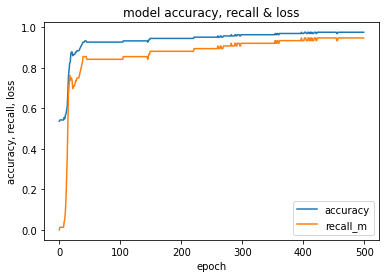

<IPython.core.display.Javascript object>

In [51]:
# Visualize the models accuracy and loss
plt.plot(history.history["accuracy"])
plt.plot(history.history["recall_m"])
# plt.plot(history.history["loss"])
plt.title("model accuracy, recall & loss")
plt.ylabel("accuracy, recall, loss")
plt.xlabel("epoch")
plt.legend(["accuracy", "recall_m", "loss"], loc="lower right")
plt.show()

In [24]:
# Prediction
pred = model.predict(X_test)

<IPython.core.display.Javascript object>

In [25]:
# Evaluate on test set
scores = model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 1ms/step - loss: 0.0838 - accuracy: 0.9859 - recall_m: 0.9762


<IPython.core.display.Javascript object>

In [26]:
# Evaluate on training set
scores_train = model.evaluate(X_train, y_train)

6/6 [==============================] - 0s 1ms/step - loss: 0.0346 - accuracy: 0.9756 - recall_m: 0.9562


<IPython.core.display.Javascript object>

In [27]:
# Evaluate the trained model on training set filtered by age, for every 10% percentile of age


def calculate_model_metrics_for_age(model, age_threshold):
    age_threshold_filter_lt = X_train["age"] <= age_threshold
    age_threshold_filter_gt = X_train["age"] > age_threshold

    age_threshold_filter_test_lt = X_test["age"] <= age_threshold
    age_threshold_filter_test_gt = X_test["age"] > age_threshold

    # Evaluate the model on the items in the training set BELOW the threshold
    lt_metrics_train = model.evaluate(
        X_train[age_threshold_filter_lt], y_train[age_threshold_filter_lt], verbose=0
    )
    gt_metrics_train = model.evaluate(
        X_train[age_threshold_filter_gt], y_train[age_threshold_filter_gt], verbose=0
    )
    # Evaluate the model on the items in the test set BELOW the threshold
    lt_metrics_test = model.evaluate(
        X_test[age_threshold_filter_test_lt],
        y_test[age_threshold_filter_test_lt],
        verbose=0,
    )
    gt_metrics_test = model.evaluate(
        X_test[age_threshold_filter_test_gt],
        y_test[age_threshold_filter_test_gt],
        verbose=0,
    )
    return (lt_metrics_train, gt_metrics_train, lt_metrics_test, gt_metrics_test)


def evaluate_model_for_age_groups(model):
    print("**** Evaluate model recall for train and test set across age groups ****")
    metrics = list()
    for age_threshold_percentile in list(np.linspace(0.3, 0.9, 8)):
        # for age_threshold_percentile in [0.01, 0.25, 0.5, 0.75, 0.99]:
        age_threshold = df["age"].quantile(age_threshold_percentile)
        (
            lt_metrics_train,
            gt_metrics_train,
            lt_metrics_test,
            gt_metrics_test,
        ) = calculate_model_metrics_for_age(model, age_threshold)
        #print(
        #    "Age Threshold: {:0.0f} train_recall (LT, GT): {:0.2f},{:0.2f} test_recall (LT, GT): {:0.2f},{:0.2f}".format(
        #        age_threshold,
        #        lt_metrics_train[2],
        #        gt_metrics_train[2],
        #        lt_metrics_test[2],
        #        gt_metrics_test[2],
        #    )
        print(
            "Age Threshold < {:0.0f}: recall={:0.2f}".format(
                age_threshold,
                lt_metrics_train[2]
            )
        )
        metrics.append((age_threshold, lt_metrics_train[2]))
    return metrics
        


<IPython.core.display.Javascript object>

In [28]:
orig_model_metrics = evaluate_model_for_age_groups(model)

**** Evaluate model recall for train and test set across age groups ****
Age Threshold < 28: recall=0.77
Age Threshold < 31: recall=0.88
Age Threshold < 35: recall=0.89
Age Threshold < 40: recall=0.94
Age Threshold < 43: recall=0.94
Age Threshold < 45: recall=0.92
Age Threshold < 48: recall=0.95
Age Threshold < 54: recall=0.95


<IPython.core.display.Javascript object>

### Conclusion: its a great model for adults, but performs poorly for non-adults less than 20 years of age

## TFCO model

References:

https://www.tensorflow.org/responsible_ai/fairness_indicators/tutorials/Fairness_Indicators_TFCO_CelebA_Case_Study

https://github.com/google-research/tensorflow_constrained_optimization/blob/master/examples/jupyter/Fairness_adult.ipynb

https://github.com/google-research/tensorflow_constrained_optimization/blob/master/README.md

In [29]:
import tensorflow_constrained_optimization as tfco

<IPython.core.display.Javascript object>

In [30]:
set_seeds()

<IPython.core.display.Javascript object>

In [31]:
## Enable eager execution
if tf.__version__ < "2.0.0":
    tf.compat.v1.enable_eager_execution()
    print("Eager execution enabled.")
else:
    print("Eager execution enabled by default.")

print("TensorFlow " + tf.__version__)

Eager execution enabled by default.
TensorFlow 2.4.0


<IPython.core.display.Javascript object>

In [32]:
# This is a small data set so train the entire batch at once
batch_size = X_train.shape[0]
num_features = X_train.shape[1]

<IPython.core.display.Javascript object>

In [33]:
# Create a contrained model from the original model
model_constrained = create_model()

<IPython.core.display.Javascript object>

As documented in TFCO's library, there are several helpers that will make it easier to constrain the problem:

1. tfco.rate_context() – This is what will be used in constructing a constraint for each age group category.
2. tfco.RateMinimizationProblem()– The rate expression to be minimized here will be the recall rate subject to age group. In other words, performance now will be evaluated based on the difference between the recall rates of the age group and that of the overall dataset. For this demonstration, a recall rate of greater than 80%-95% will be set as the constraint.
3. tfco.ProxyLagrangianOptimizerV2() – This is the helper that will actually solve the rate constraint problem.

The cell below will call on these helpers to set up model training with the fairness constraint.

In [34]:
# Create input tensor: TODO -> use len(columns_to_retain) - 1 to create this
input_tensor = tf.Variable(
    np.zeros((batch_size, num_features), dtype="float32"), name="input"
)

<IPython.core.display.Javascript object>

In [35]:
# Create labels and group tensors (both are binary)
labels_tensor = tf.Variable(np.zeros(batch_size, dtype="float32"), name="labels")
groups_tensor = tf.Variable(np.zeros(batch_size, dtype="float32"), name="groups")

<IPython.core.display.Javascript object>

In [36]:
# Create a function that returns the applied 'model' to the input tensor
# and generates constrained predictions.
def predictions():
    return model_constrained(input_tensor)

<IPython.core.display.Javascript object>

In [37]:
# Create overall context and subsetted context.
# The subsetted context contains subset of examples where group attribute > 0
# (i.e. the subset of "Young" images).
# "groups_tensor > 0" is used instead of "groups_tensor == 1" as the former
# would be a comparison on the tensor value, while the latter would be a
# comparison on the Tensor object.
context = tfco.rate_context(predictions, labels=lambda: labels_tensor)
context_subset = context.subset(lambda: groups_tensor > 0)

<IPython.core.display.Javascript object>

### Setup list of constraints. We will constrain the recall to be at least 90%

In [38]:
# Setup list of constraints.
# *We will constrain the recall to be at least 90%*
recall_lower_bound = 0.90
constraints = [tfco.recall(context_subset) >= recall_lower_bound]

<IPython.core.display.Javascript object>

In [39]:
# Setup rate minimization problem: minimize overall error rate s.t. constraints are satisfied.
problem = tfco.RateMinimizationProblem(tfco.error_rate(context), constraints)

<IPython.core.display.Javascript object>

In [40]:
# Create constrained optimizer and obtain train_op.
# Separate optimizers are specified for the objective and constraints.
optimizer = tfco.ProxyLagrangianOptimizerV2(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    # constraint_optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    constraint_optimizer=tf.keras.optimizers.Adagrad(learning_rate=1),
    num_constraints=problem.num_constraints,
)

<IPython.core.display.Javascript object>

In [41]:
# A list of all trainable variables is also needed to use TFCO.
var_list = (
    model_constrained.trainable_weights
    + list(problem.trainable_variables)
    + optimizer.trainable_variables()
)

<IPython.core.display.Javascript object>

In [42]:
# Debug info
# print("Model trainable vars: {}".format(model_constrained.trainable_weights))
# print("Problem trainable vars: {}".format(problem.trainable_variables))
# print("Optimizer trainable vars: {}".format(optimizer.trainable_variables()))

<IPython.core.display.Javascript object>

In [43]:
# List of objective and constraints across iterations.
objective_list = []
violations_list = []

# Assign batch to input, labels and group tensors
# Since we are training the full batch, this assignment is outside the loop.
# If we need mini-batch, this would be inside the loop.
input_tensor.assign(X_train)
labels_tensor.assign(y_train)
groups_tensor.assign(group_train)

# Training iterations.
iteration_count = 0
for iteration_count in range(n_epochs):
    # Run gradient update
    optimizer.minimize(problem, var_list=var_list)

    #   # Record objective and violations.
    objective = problem.objective()
    violations = problem.constraints()

    print(
        "\r Iteration %d: Hinge Loss = %.3f, Max. Constraint Violation = %.3f"
        % (iteration_count + 1, objective, max(violations))
    )

 Iteration 1: Hinge Loss = 2.288, Max. Constraint Violation = 0.789
 Iteration 2: Hinge Loss = 2.038, Max. Constraint Violation = 0.789
 Iteration 3: Hinge Loss = 1.748, Max. Constraint Violation = 0.789
 Iteration 4: Hinge Loss = 1.430, Max. Constraint Violation = 0.789
 Iteration 5: Hinge Loss = 1.107, Max. Constraint Violation = 0.789
 Iteration 6: Hinge Loss = 0.913, Max. Constraint Violation = 0.567
 Iteration 7: Hinge Loss = 0.882, Max. Constraint Violation = 0.233
 Iteration 8: Hinge Loss = 0.875, Max. Constraint Violation = -0.100
 Iteration 9: Hinge Loss = 0.851, Max. Constraint Violation = -0.100
 Iteration 10: Hinge Loss = 0.791, Max. Constraint Violation = -0.100
 Iteration 11: Hinge Loss = 0.667, Max. Constraint Violation = 0.011
 Iteration 12: Hinge Loss = 0.505, Max. Constraint Violation = 0.011
 Iteration 13: Hinge Loss = 0.359, Max. Constraint Violation = 0.122
 Iteration 14: Hinge Loss = 0.269, Max. Constraint Violation = 0.344
 Iteration 15: Hinge Loss = 0.246, Max. 

 Iteration 122: Hinge Loss = 0.124, Max. Constraint Violation = 0.011
 Iteration 123: Hinge Loss = 0.122, Max. Constraint Violation = 0.011
 Iteration 124: Hinge Loss = 0.117, Max. Constraint Violation = 0.011
 Iteration 125: Hinge Loss = 0.114, Max. Constraint Violation = 0.011
 Iteration 126: Hinge Loss = 0.114, Max. Constraint Violation = 0.011
 Iteration 127: Hinge Loss = 0.117, Max. Constraint Violation = 0.011
 Iteration 128: Hinge Loss = 0.119, Max. Constraint Violation = 0.011
 Iteration 129: Hinge Loss = 0.117, Max. Constraint Violation = 0.011
 Iteration 130: Hinge Loss = 0.114, Max. Constraint Violation = 0.011
 Iteration 131: Hinge Loss = 0.112, Max. Constraint Violation = 0.011
 Iteration 132: Hinge Loss = 0.111, Max. Constraint Violation = 0.011
 Iteration 133: Hinge Loss = 0.111, Max. Constraint Violation = 0.011
 Iteration 134: Hinge Loss = 0.113, Max. Constraint Violation = 0.011
 Iteration 135: Hinge Loss = 0.113, Max. Constraint Violation = 0.011
 Iteration 136: Hing

 Iteration 243: Hinge Loss = 0.091, Max. Constraint Violation = 0.011
 Iteration 244: Hinge Loss = 0.089, Max. Constraint Violation = 0.011
 Iteration 245: Hinge Loss = 0.090, Max. Constraint Violation = 0.011
 Iteration 246: Hinge Loss = 0.093, Max. Constraint Violation = 0.011
 Iteration 247: Hinge Loss = 0.097, Max. Constraint Violation = -0.100
 Iteration 248: Hinge Loss = 0.099, Max. Constraint Violation = -0.100
 Iteration 249: Hinge Loss = 0.100, Max. Constraint Violation = -0.100
 Iteration 250: Hinge Loss = 0.098, Max. Constraint Violation = -0.100
 Iteration 251: Hinge Loss = 0.095, Max. Constraint Violation = -0.100
 Iteration 252: Hinge Loss = 0.091, Max. Constraint Violation = 0.011
 Iteration 253: Hinge Loss = 0.089, Max. Constraint Violation = 0.011
 Iteration 254: Hinge Loss = 0.087, Max. Constraint Violation = 0.011
 Iteration 255: Hinge Loss = 0.087, Max. Constraint Violation = 0.011
 Iteration 256: Hinge Loss = 0.089, Max. Constraint Violation = 0.011
 Iteration 257:

 Iteration 360: Hinge Loss = 0.065, Max. Constraint Violation = 0.011
 Iteration 361: Hinge Loss = 0.065, Max. Constraint Violation = 0.011
 Iteration 362: Hinge Loss = 0.064, Max. Constraint Violation = 0.011
 Iteration 363: Hinge Loss = 0.062, Max. Constraint Violation = 0.011
 Iteration 364: Hinge Loss = 0.061, Max. Constraint Violation = 0.011
 Iteration 365: Hinge Loss = 0.062, Max. Constraint Violation = 0.011
 Iteration 366: Hinge Loss = 0.063, Max. Constraint Violation = 0.011
 Iteration 367: Hinge Loss = 0.065, Max. Constraint Violation = -0.100
 Iteration 368: Hinge Loss = 0.065, Max. Constraint Violation = -0.100
 Iteration 369: Hinge Loss = 0.064, Max. Constraint Violation = -0.100
 Iteration 370: Hinge Loss = 0.063, Max. Constraint Violation = 0.011
 Iteration 371: Hinge Loss = 0.061, Max. Constraint Violation = 0.011
 Iteration 372: Hinge Loss = 0.059, Max. Constraint Violation = 0.011
 Iteration 373: Hinge Loss = 0.059, Max. Constraint Violation = 0.011
 Iteration 374: H

 Iteration 480: Hinge Loss = 0.044, Max. Constraint Violation = 0.011
 Iteration 481: Hinge Loss = 0.043, Max. Constraint Violation = 0.011
 Iteration 482: Hinge Loss = 0.044, Max. Constraint Violation = 0.011
 Iteration 483: Hinge Loss = 0.044, Max. Constraint Violation = 0.011
 Iteration 484: Hinge Loss = 0.045, Max. Constraint Violation = 0.011
 Iteration 485: Hinge Loss = 0.044, Max. Constraint Violation = 0.011
 Iteration 486: Hinge Loss = 0.044, Max. Constraint Violation = 0.011
 Iteration 487: Hinge Loss = 0.043, Max. Constraint Violation = 0.011
 Iteration 488: Hinge Loss = 0.043, Max. Constraint Violation = 0.011
 Iteration 489: Hinge Loss = 0.042, Max. Constraint Violation = 0.011
 Iteration 490: Hinge Loss = 0.042, Max. Constraint Violation = 0.011
 Iteration 491: Hinge Loss = 0.042, Max. Constraint Violation = 0.011
 Iteration 492: Hinge Loss = 0.042, Max. Constraint Violation = 0.011
 Iteration 493: Hinge Loss = 0.042, Max. Constraint Violation = 0.011
 Iteration 494: Hing

<IPython.core.display.Javascript object>

## Metrics and plots

In [44]:
# Original model
orig_model_metrics = evaluate_model_for_age_groups(model)

**** Evaluate model recall for train and test set across age groups ****
Age Threshold < 28: recall=0.77
Age Threshold < 31: recall=0.88
Age Threshold < 35: recall=0.89
Age Threshold < 40: recall=0.94
Age Threshold < 43: recall=0.94
Age Threshold < 45: recall=0.92
Age Threshold < 48: recall=0.95
Age Threshold < 54: recall=0.95


<IPython.core.display.Javascript object>

In [45]:
# New model
new_model_metrics = evaluate_model_for_age_groups(model_constrained)

**** Evaluate model recall for train and test set across age groups ****
Age Threshold < 28: recall=0.90
Age Threshold < 31: recall=0.92
Age Threshold < 35: recall=0.93
Age Threshold < 40: recall=0.96
Age Threshold < 43: recall=0.95
Age Threshold < 45: recall=0.94
Age Threshold < 48: recall=0.96
Age Threshold < 54: recall=0.96


<IPython.core.display.Javascript object>

In [46]:
new_model_metrics

[(28.0, 0.8999999761581421),
 (31.0, 0.9153439402580261),
 (35.3142857142857, 0.925000011920929),
 (40.0, 0.9615384340286255),
 (43.0, 0.9545454382896423),
 (45.485714285714295, 0.9375),
 (48.0, 0.9589285850524902),
 (54.0, 0.9644444584846497)]

<IPython.core.display.Javascript object>

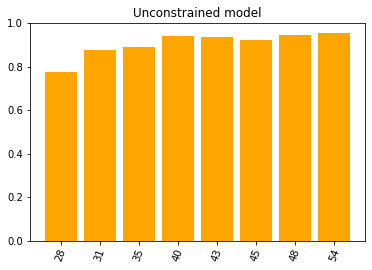

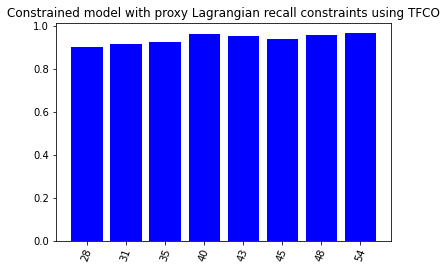

<IPython.core.display.Javascript object>

In [47]:
def plot_age_recall_barplot(model_metrics, title="barplot", color="blue"):
    plt.bar(range(len(model_metrics)), [val[1] for val in model_metrics], color=color)
    plt.xticks(range(len(model_metrics)), [int(val[0]) for val in model_metrics])
    plt.xticks(rotation=70)
    plt.title(title)
    plt.show()


plot_age_recall_barplot(orig_model_metrics, "Unconstrained model", "orange")
plot_age_recall_barplot(
    new_model_metrics,
    "Constrained model with proxy Lagrangian recall constraints using TFCO",
    "blue",
)

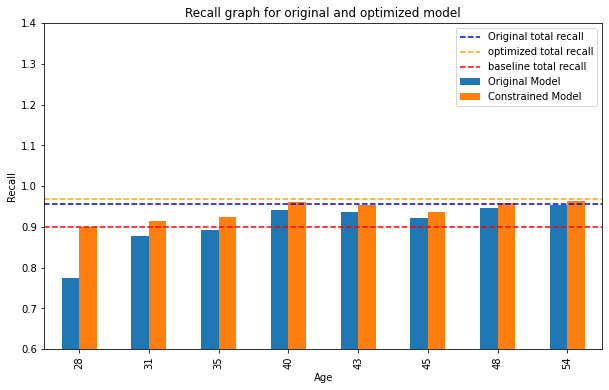

<IPython.core.display.Javascript object>

In [48]:
# Plot data side by side on the same graph.

# Put the data into one dataframe to plot them side-by-side
age = list(zip(*orig_model_metrics))[0]
original_model_metrics = list(zip(*orig_model_metrics))[1]
constrained_model_metrics = list(zip(*new_model_metrics))[1]
plot_df = pd.DataFrame(
    {
        "Age": age,
        "Original Model": original_model_metrics,
        "Constrained Model": constrained_model_metrics,
    },
)
plot_df["Age"] = plot_df["Age"].astype(int)
plot_df = plot_df.set_index("Age")

# Draw barplot of the original and optimized data for each age-group.
ax = plot_df.plot(
    kind="bar",
    figsize=(10, 6),
    title="Recall graph for original and optimized model",
    xlabel="Age",
    ylabel="Recall",
    ylim=(0.6, 1.4),
)

# Add horizontal lines for baseline recall, original recall and optimized recall
original_recall = calculate_model_metrics_for_age(model, 99)[0][2]
new_recall = calculate_model_metrics_for_age(model_constrained, 99)[0][2]
baseline_recall = 0.9
plt.axhline(
    y=original_recall, color="blue", linestyle="dashed", label="Original total recall"
)
plt.axhline(
    y=new_recall, color="orange", linestyle="dashed", label="optimized total recall"
)
plt.axhline(
    y=baseline_recall, color="red", linestyle="dashed", label="baseline total recall"
)

# Draw the plots
plt.legend()
plt.show()

## Conclusions

We can conclude from the above results comparing the original unconstrained and new recall-constrained model, that the directly optimizing for recall to be above 0.90 using the TFCO's lagrangian optimizer made a significant improvement in improving the recall of the age group < 30. The key benefit is that the recall was uniformly kept high above 90% over the different age groups.

The study meets its objectives:
1. Demonstrate that naive training can result in some subsets of the data having poor results. In this case, the lower age groups have low recall. Low recall can result in missed early diagnosis of Kidney Disease and potential loss of life.
2. Demonstrate that explicit optimizing for recall for subsets such as lower or higher ages can result in a more reliable model with better results across all the targeted sub-categories.
3. Use Lagrange-based proxy optimizers to control for age sub-group results in consistent high results above 90% recall.
4. This is a very general approach which can be applied to most machine learning models. Hence it can be used broadly in the multiple medical ML studies to yield more reliable models.

Overall, the result of the new model compared to the old model is very clear and results in a recall over 0.90 over all age groups, which is a huge and life-saving improvement of the model. This was achieved as a direct result of optimizing for a target value of recall during the training process.